# Graph RAG テスト


こちらを参考にGraph RAGを構築TEST：

* エンジニアのためのGraphRAG入門: 知識グラフ活用の第一歩
    https://zenn.dev/fukurou_labo/articles/f0c233eb5aebb7


### Langchainとneo4jを用いてGraphを構築

[前準備]
1) LangchainのAPIを使用するため、LangchainにサインインしてAPIキーを取得：

    https://www.langchain.com/  

2) langchain・langchain-openai・langchain-community・langchain-experimentalをインストール:

    pip install -U langchain langchain-openai　langchain-community　langchain-experimental

3) グラフ化に使用するNeo4jのAuraDB(無料版)にサブスクライブ:

    https://neo4j.com/release-notes/aura/aura-september-2024-neo4j-5-24/

    (!Warning! 無料版は30日間非アクティブの場合、自動でインスタンスが削除されるので注意)

4) Neo4jのインスタンス作成、接続用URIとPASSWORD取得


#### モジュールインポート


In [1]:
import os
from langchain_community.graphs import Neo4jGraph
from langchain.document_loaders import TextLoader
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain.text_splitter import CharacterTextSplitter
import pprint

In [2]:
# import getpass

# 初回のみ! openaiのAPIキーを設定
# OpenAI APIのアカウントを作成、
# https://platform.openai.com/account/api-keys
# からAPIキーを取得して環境変数に設定

# os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OPENAI_API_KEY: ")

# # 初回のみ! Neo4jの認証情報を設定
# os.environ["NEO4J_URI"] = "neo4j+s://4c1969e1.databases.neo4j.io"
# os.environ["NEO4J_USERNAME"] = "neo4j"
# os.environ["NEO4J_PASSWORD"] = getpass.getpass("Enter your NEO4J_PASSWORD: ")

#### テキスト分割

(後でグラフを生成する際に用いられる、ベクトル化するためのチャンク作成)

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

# raw_documents = TextLoader('./data/manufacturing_company_dummy_v2.txt').load()
raw_documents = TextLoader('./data/GRPHRG株式会社_社員スキル.txt').load()

#!org! text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
text_splitter = CharacterTextSplitter(
    separator="。\n\n",
    chunk_size=200, 
    chunk_overlap=0
    )
documents = text_splitter.split_documents(raw_documents)

print(f"{len(documents)} chunks")
documents

#### 入力されたドキュメントを解析し、グラフのノードとエッジを生成

In [ ]:
# !このコードの実行前にAuraDBのインスタンスを起動しておく!

# グラフ作成に使用するLLMを設定
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
llm_transformer = LLMGraphTransformer(llm=llm)


graph = Neo4jGraph()

#グラフ初期化
graph.query("MATCH (n) DETACH DELETE n")

# グラフ作成を実行
graph_documents = llm_transformer.convert_to_graph_documents(documents)
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

# cypherでqueryできるか確認
pprint.pprint(graph.query("MATCH p=()-[]->() RETURN p"))

#### 生成されたグラフを表示

In [ ]:
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 10000"
# default_cypher = 'MATCH (s)-[r:!MENTIONS]->(t) \
#         WHERE s.id = "佐藤一郎"\
#         OR s.id = "加藤正志" \
#         OR t.id = "佐藤一郎" \
#         OR t.id = "加藤正志" \
#         RETURN s,r,t'

def showGraph(cypher: str = default_cypher):
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (
            os.environ["NEO4J_USERNAME"],
            os.environ["NEO4J_PASSWORD"]
        )
    )
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    return widget

showGraph()

#### 生成されたグラフの例 

* **ダミーデータ(manufacturing_company_dummy.txt)**

[全体]

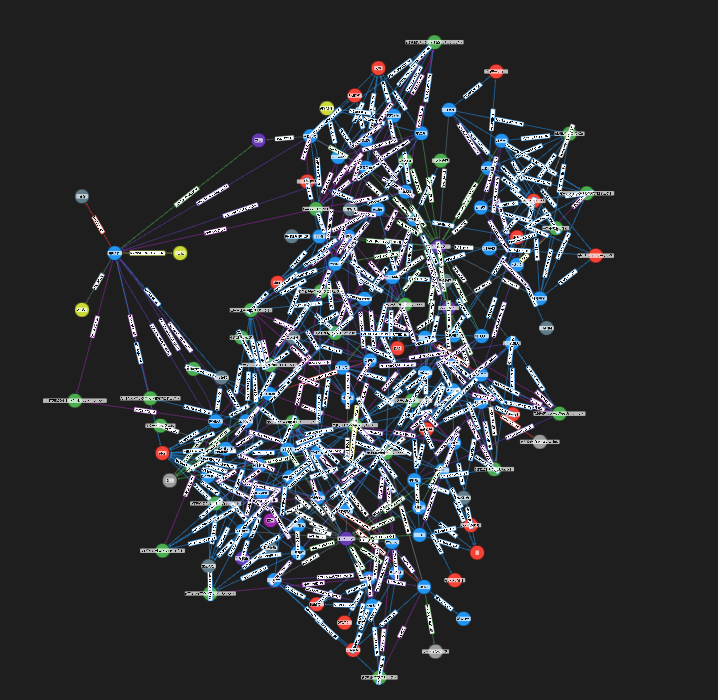

[山田太郎さん中心]

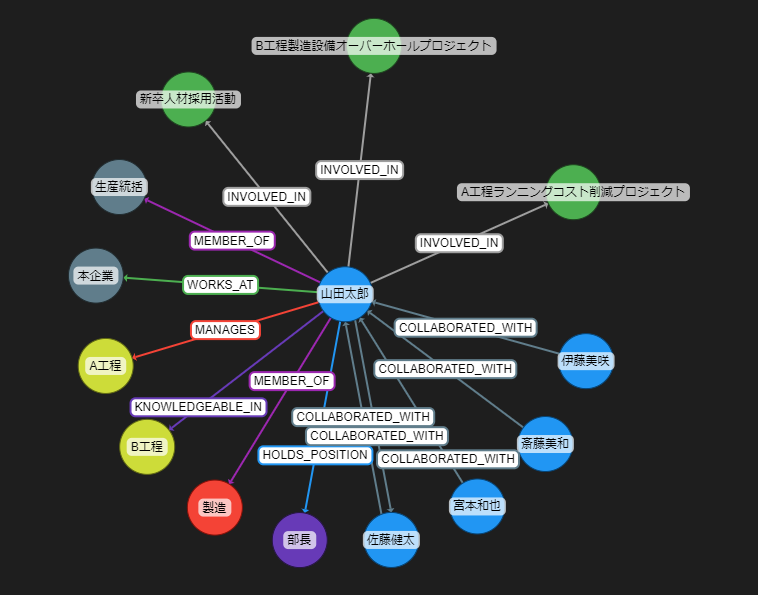


* **v2ダミーデータ(manufacturing_company_dummy_v2.txt)**
2名の社員抜粋:

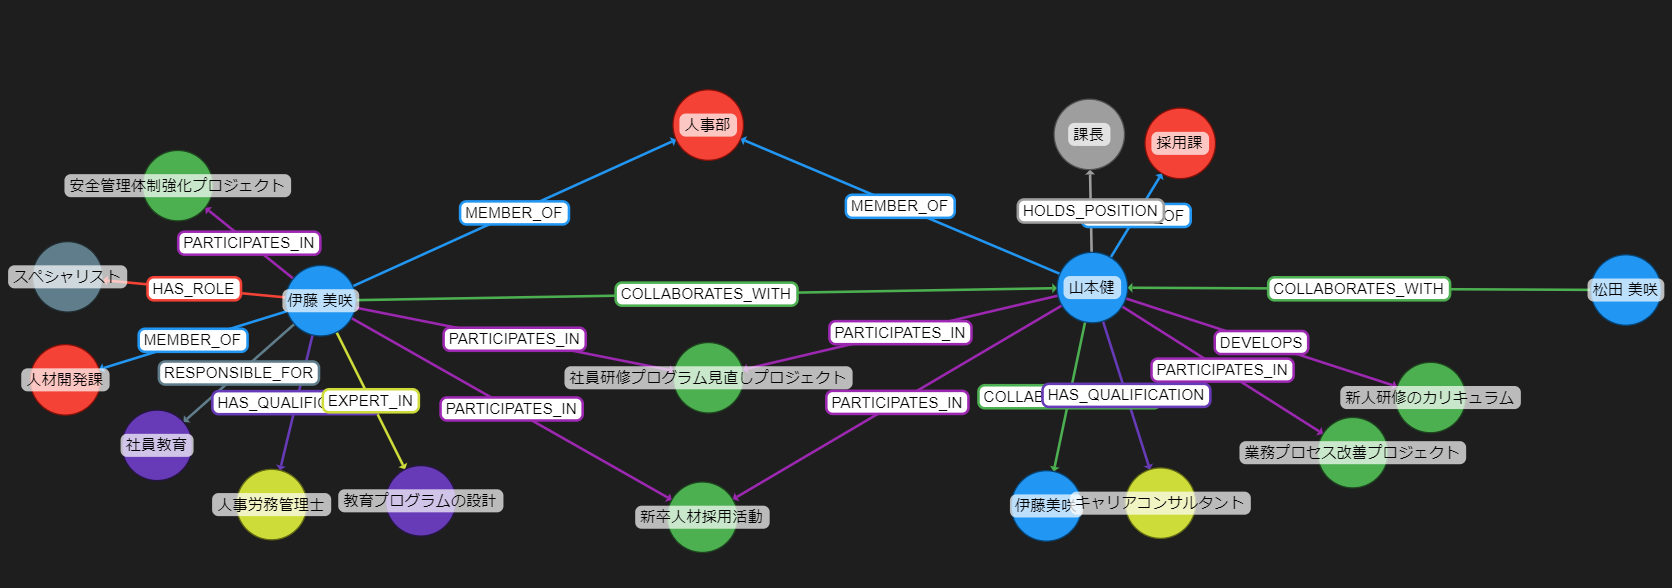


->HAS_QUALIFICATIONやEXPERT_INといったスキル関連のエッジ (エンティティ間の関係性を示す線) が作成されていることを確認！


* skillダミーデータ

[全体]

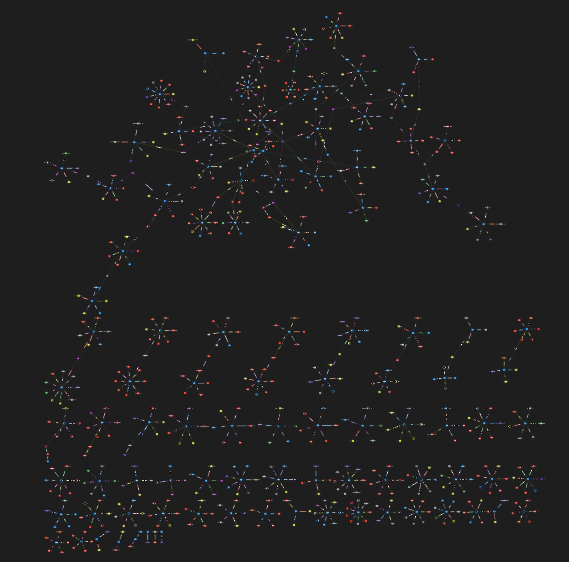

[佐藤一郎・加藤正志さん中心]

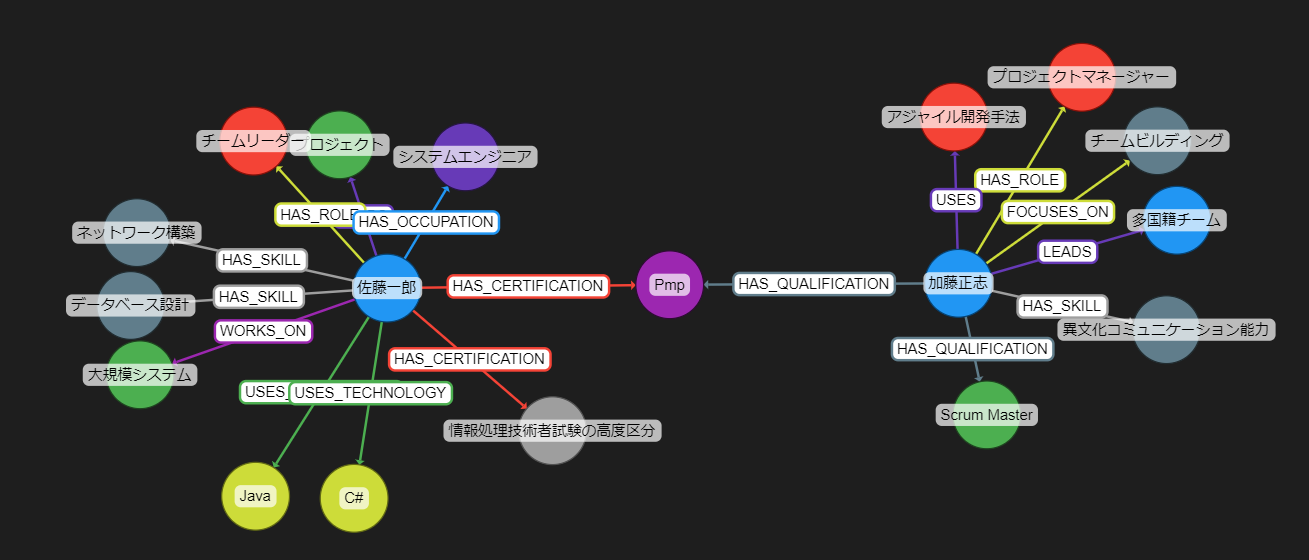


* おまけ：ポケモンWiki(フシギダネとその進化系)

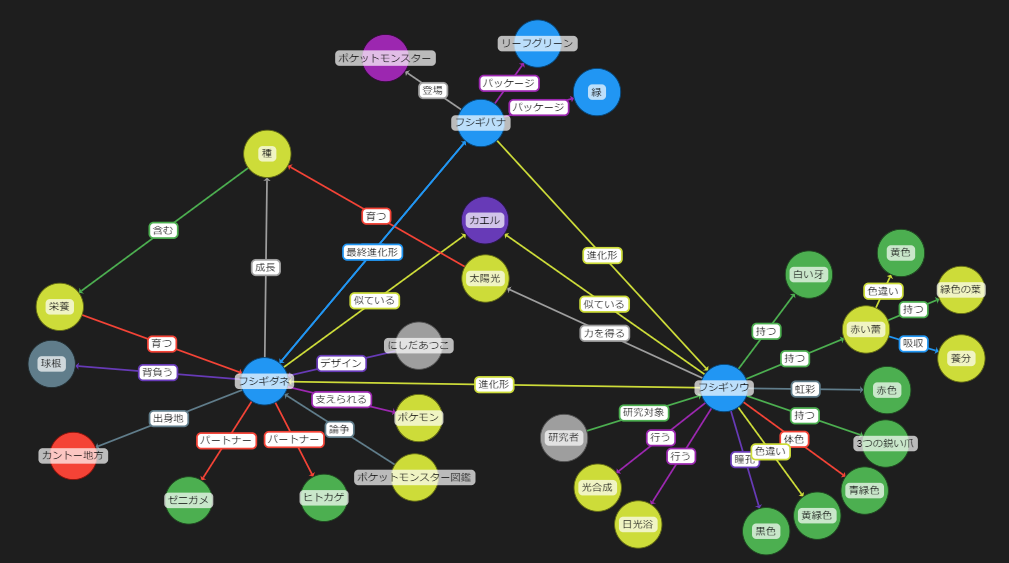




#### 5)　グラフデータを参照して回答生成

In [ ]:
import os
from typing import Tuple, List
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars


チャットでの会話を成り立たせるために、ユーザーのオリジナルの質問とは別に、会話履歴も加味して改めて独立した質問文を作成する処理:

In [5]:
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name = "HasChatHistoryCheck"
        ),
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | ChatOpenAI(temperature=0)
        | StrOutputParser(),
    ),
    RunnableLambda(lambda x : x["question"]),
)

#### グラフデータ（構造化データ）とベクトルデータ（非構造化データ）を組み合わせて、質問に対する回答を生成するためのRetrieverを定義

In [33]:
graph = Neo4jGraph()
graph.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]"
)

class Entities(BaseModel):
    names: List[str] = Field(
        ...,
        # description="All the persons, organizations, business entities, and material things that appear in the text",
        # 改良案
        description="A list of entities extracted from the text, including names of people, organizations, "
                    "businesses, and tangible objects. This class is used to structure and manage entity data "
                    "for further analysis or processing.",
        #　日本語版
        # description="文章の中に登場する、人物、各人物間の関係、各人物が所属する組織、各人物間の職業、各人物のスキルや資格",
        
    )

def generate_full_text_query(input: str) -> str:
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word} AND"
    full_text_query += f" {words[-1]}"
    return full_text_query.strip()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following input: {question}",
        ),
    ]
)
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini") #gpt-4oだとなぜかエンティティが抽出されないのでgpt-4o-miniを設定
entity_chain = prompt | llm.with_structured_output(Entities)

def structured_retriever(question: str) -> str:
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              WITH node
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION ALL
              WITH node
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question, k=10)] #チャンク数kはここで調整
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    print(f"{final_data}")
    return final_data

template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)
chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

#### ***質問をして動作を確認***

In [ ]:
# 質問を入力してください:


# <定量的質問>
# question = "データ分析のスキルを持つ社員を全員リストアップしてください。"
question = "プロジェクトマネジメントの経験を持つ社員を全員リストアップしてください。"
# question = "藤田玲奈のTOEICスコアは何点ですか？"
# question = "全社員についての情報の中で、プログラミング言語は何種類リストアップされてますか？"
# question = "プロジェクトマネジメント資格（PMP）を保有している社員は何名いますか？"


# <定性的質問>
# question = "この企業の社員のスキルはどういうものが多いのかを整理してください"
# question = "マーケティングの知識が最も豊富だと考えられる社員は誰ですか？"
# question = "佐々木健太さんはどういった社員ですか？"
# question = "藤井健太さんと近いスキルセットを持つ社員と、そのスキルセットについてそれぞれ教えてください。"
# question = """
#             この企業内で生産ラインのDXプロジェクトを企画することになりました。プロジェクトを成功させることができる、以下の{#スキル}のどれかを持つ社員をちょうど10名選定し、
#             プロジェクトにおける役割を明確にせよ。日本語で回答すること。
#             {#スキル}
#             1. プロジェクトマネジメント
#             2. データ解析
#             3. システム開発
#             4. プロセス改善
#             5. 現場の技術知識
#             """   

result = chain.invoke({"question": question})

result

#### v1ダミーデータ使用時:manufacturing_company_dummy.txt

* ユーザ質問：
    「山田太郎と一緒にプロジェクトに従事したことがある社員を全員挙げてください」

* LLMの回答：

    「山田太郎と一緒にプロジェクトに従事したことがある社員は、佐藤健太、伊藤美咲、斎藤美和、宮本和也の4名です。」


# 大正解！

実際のソーステキストの抜粋：


名前： <span style="background-color: green;">佐藤健太</span>
所属部門： 製造
所属部署： 生産統括
役職： 課長
経歴詳細：
入社15年目で、B工程の生産ライン管理を担当。<mark>山田太郎</mark>と協働し、B工程製造設備オーバーホールプロジェクトを成功に導いた。これまで関わったプロジェクトは以下の通り：
B工程製造設備オーバーホールプロジェクト
C工程生産性向上プロジェクト
安全管理体制強化プロジェクト

名前： <span style="background-color: green;">伊藤美咲</span>
所属部門： 人事
所属部署： 人材開発
役職： 部長
経歴詳細：
新卒人材採用活動をリードし、優秀な人材の確保に貢献。<mark>山田太郎</mark>と協力して社員研修プログラム見直しプロジェクトを推進。参加したプロジェクト：
新卒人材採用活動
社員研修プログラム見直しプロジェクト
コスト削減アイデア募集活動

名前： <span style="background-color: green;">斎藤美和</span>
所属部門： 人事
所属部署： 労務管理
役職： スペシャリスト
経歴詳細：
社員研修プログラム見直しプロジェクトで伊藤美咲をサポート。<mark>山田太郎</mark>とも新卒人材採用活動で協力。関わったプロジェクト：
社員研修プログラム見直しプロジェクト
新卒人材採用活動
安全管理体制強化プロジェクト

名前： <span style="background-color: green;">宮本和也</span>
所属部門： 製造
所属部署： 生産統括
役職： 課長
経歴詳細：
A工程の生産ライン管理を担当。<mark>山田太郎</mark>とA工程ランニングコスト削減プロジェクトで協力。参加したプロジェクト：
A工程ランニングコスト削減プロジェクト
コスト削減アイデア募集活動
安全管理体制強化プロジェクト

他に該当者なし！

#### v2ダミーデータ使用時:manufacturing_company_dummy_v2.txt

* ユーザ質問：
    「環境負荷低減プロジェクトに関わった社員全員を挙げてください。」

* LLMの回答：

    「'環境負荷低減プロジェクトに関わった社員は以下の通りです：1. 鈴木花子 2. 佐々木玲 3. 小林涼子 4. 福田美紀 
       5. 宮崎大輔 6. 野村一郎'」


# 大正解！


#### skillダミーデータ使用時:GRPHRG株式会社_社員スキル.txt

* ユーザ質問：
    「この文章の内容から、この企業の社員のスキルはどういうものが多いのかを整理してください」

* LLMの回答：

    「'この企業の社員は、技術的スキルと専門的資格を多く持っていることが特徴です。
    具体的には、システムエンジニアリング、データ分析、ネットワーク構築、教育テクノロジー、法務知財、製造プロセス最適化などの分野で高度なスキルを持つ社員が多くいます。
    また、PMP、CCNA、LPIC、キャリアコンサルタント、弁理士などの専門資格を保有している社員も多く、各分野での専門性が高いことが伺えます。
    さらに、社員教育やキャリアパス設計、メンタルヘルスケアなど、社員の成長と職場環境の改善に貢献するスキルも重視されています。'」

    <比較用：Baseline RAG の回答>
    「1. **人事・組織開発**:
   - 採用と研修の担当
   - 社会保険労務士の資格
   - 組織開発や社員教育プログラムの企画・運営
   - 労働法の知識とコンプライアンス遵守の推進

    2. **コンテンツマーケティング**:
    - ブログやホワイトペーパーの制作
    - ウェブ解析士の資格
    - SEOやコンバージョン最適化
    - コピーライティングのスキル

    3. **営業**:
    - 国内外の大手クライアントの担当
    - ビジネス英語検定準1級
    - 高度な交渉力とプレゼンテーションスキル
    - CRMシステムの活用

    4. **データ分析**:
    - データ分析とビジネスインサイトの提供
    - ビッグデータ解析の資格
    - 機械学習アルゴリズムを用いた予測モデルの構築
    - データビジュアライゼーションのスキル

    このように、社員はそれぞれの専門分野で高度なスキルと資格を持ち、企業の多様なニーズに対応しています。」

**-><span style="background-color: green;">Baselineよりも包括的、かつ専門資格とスキルを分けてより構造的に整理している。社員の成長と職場環境の改善に貢献するスキルについても触れている！</span>**
    


#### v2ダミーデータ使用時

* ユーザ質問：
    「この企業内で生産ラインのDXプロジェクトを企画することになりました。プロジェクトを成功させることができる、以下の{#スキル}を一つ以上持つ社員を10名選定せよ。
            {#スキル}
            1. プロジェクトマネジメント
            2. データ解析
            3. システム開発
            4. プロセス改善
            5. 現場の技術知識
   」

* LLMの回答：

    「以下の10名の社員が生産ラインのDXプロジェクトに適しています。

1. 菅原 拓也 - 企業ガバナンスに貢献
2. 中村裕子 - 営業部のメンバー
3. 木村 翔 - 営業部のメンバー、ベンダー選定プロジェクト参加
4. 松本 彩 - 営業部のメンバー、データ分析に熟練
5. 長谷川結衣 - 営業部のメンバー、品質管理システム改善プロジェクト参加
6. 藤田 直人 - プロジェクト管理課のメンバー、業務プロセス改善プロジェクト参加
7. 山本健 - 社員研修プログラム見直しプロジェクト参加、業務プロセス改善プロジェクト参加
8. 三浦 夏美 - 生産技術課のエンジニア、プロセス改善に貢献
9. 加藤 直樹 - 技術支援課のエンジニア、生産技術に精通
10. 大野 由紀 - 組織開発課のスペシャリスト、業務プロセス改善プロジェクト参加

これらの社員は、プロジェクトマネジメント、データ解析、プロセス改善、現場の技術知識などのスキルを持っています。」


#### skillダミーデータ使用時

* ユーザ質問：
「この企業内で生産ラインのDXプロジェクトを企画することになりました。プロジェクトを成功させることができる、以下の{#スキル}のどれかを持つ社員をちょうど10名選定し、プロジェクトにおける役割を明確にせよ。
    {#スキル}
    1. プロジェクトマネジメント
    2. データ解析
    3. システム開発
    4. プロセス改善
    5. 現場の技術知識」

   
* 取得された関連情報

Structured data:
企業 - OWNS -> データ資産

渡辺健一 - WORKS_FOR -> 企業

清水大輔 - WORKS_FOR -> 企業

川口美穂 - PROMOTES -> 企業

岡田慎太郎 - PROTECTS -> 企業

木下大輔 - SUPPORT -> 企業

学習システム - FOR -> 企業

尾崎美奈子 - MANAGES_RISK_FOR -> 企業

近藤美穂 - PLANS -> 企業イベント

森田健司 - OPTIMIZES -> 生産ライン

森田健司 - HAS_QUALIFICATION -> 生産管理士

佐藤一郎 - LEADS -> プロジェクト

原田美奈子 - FACILITATES -> 国際プロジェクト

村上美奈 - SUPPORTS -> 社員

山崎美穂 - CONSULTS -> 社員

山本幸子 - INVOLVED_IN -> 社員教育プログラム

川口美穂 - DEVELOPS -> 社員教育プログラム

高橋太郎 - HAS_SKILL -> データ分析

青木隆 - PERFORMS -> データ分析

坂本美咲 - HOLDS -> ウェブ解析士佐山健太郎 - 経験 -> シグナリングシステム開発
中山健太郎 - PERFORMS -> アルゴリズム開発村上美奈 - OFFERS -> コミュニケーション改善
野村美穂 - PERFORMS -> 業務プロセスの改善提案工藤美咲 - HAS_SKILL -> 専門知識
内田美穂 - USES -> 医療知識
Unstructured data:

text: [GRPHRG株式会社　社員スキル]
佐藤一郎は、15年の経験を持つシステムエンジニアであり、主にJavaとC#を用いた大規模システムの開発に従事している。情報処理技術者試験の高度区分を取得しており、データベース設計やネットワーク構築にも精通している。また、プロジェクトマネジメントの資格であるPMPを保有し、チームリーダーとしてプロジェクトを成功に導いた実績が豊富だ#Document 
text: 加藤正志は、プロジェクトマネージャーとして多国籍チームを率いている。PMPとScrum Masterの資格を持ち、アジャイル開発手法を導入してプロジェクトの成功率を高めている。異文化コミュニケーション能力が高く、チームビルディングにも注力している#Document 
text: 橋本彩は、プロダクトマネージャーとして新製品の企画開発をリードしている。マーケットリサーチの専門知識を持ち、ユーザーインサイトを活用した製品開発が得意だ。プロダクトライフサイクル管理のスキルも高く、市場投入から成熟期までを一貫して担当している#Document 
text: 中村亮太は、営業部のエースとして国内外の大手クライアントを担当している。ビジネス英語検定準1級を取得し、海外取引にも積極的だ。高度な交渉力とプレゼンテーションスキルで新規契約を次々と獲得している。CRMシステムの活用にも長けている#Document 
text: 石田美奈は、サプライチェーンマネージャーとして調達から販売までのプロセスを最適化している。SCMの資格を持ち、需要予測や在庫最適化によりコスト削減を実現している。EDIシステムの導入にも成功している。

佐野大輝は、ロボティクスエンジニアとして産業用ロボットの開発に携わっている。ロボット工学の知識を持ち、制御アルゴリズムやセンサー技術に詳しい。自動化ソリューションの提供で生産性向上に貢献している#Document 
text: 西村直人は、モバイルネットワークエンジニアとして通信インフラの構築を担当している。5G技術に詳しく、通信事業者との協業で新サービスの立ち上げに成功している。無線技術士の資格を持ち、電波法にも精通している。

三浦彩香は、食品開発の研究員として新商品の企画と試作を行っている。食品衛生管理者の資格を持ち、安全で美味しい製品作りに情熱を注いでいる。消費者テストで高評価を得た商品を複数リリースしている#Document 
text: 田辺美咲は、教育テクノロジーのエキスパートとして、学校や企業向けの学習システムを開発している。ICT教育の資格を持ち、AIを活用したパーソナライズドラーニングの実現に取り組んでいる。

中田健一は、建設プロジェクトマネージャーとして大規模建築物の工事を統括している。施工管理技士の資格を持ち、安全管理と品質管理に定評がある。最新の建設技術の導入にも積極的だ#Document 
text: 山本幸子は、人事部で採用と研修を担当しており、社会保険労務士の資格を持つ。組織開発や社員教育プログラムの企画・運営に携わり、社員のスキルアップと職場環境の改善に貢献している。労働法にも精通し、コンプライアンス遵守の推進役でもある#Document 
text: 太田雄一は、物流システムエンジニアとして倉庫管理システムの導入を担当している。システムアーキテクトの資格を持ち、在庫管理や出荷業務の自動化を実現している。RFID技術の活用にも取り組んでいる。

原田美奈子は、翻訳コーディネーターとして多言語プロジェクトを管理している。英語とフランス語に堪能で、翻訳士の資格を持つ。品質管理と納期管理に優れ、国際プロジェクトを円滑に進めている#Document 
text: 宮崎翔は、ITサポート部で社内システムの運用とサポートを担当している。マイクロソフト認定プロフェッショナルの資格を持ち、トラブルシューティングやユーザーサポートに定評がある。クラウドサービスの導入にも携わっている。

松田陽子は、営業企画部で市場分析と営業戦略の立案を行っている。MBAを取得しており、データドリブンな意思決定が得意だ。新規市場の開拓や、営業プロセスの改善により業績向上に貢献している
    

* LLMの回答：

「この企業内で生産ラインのDXプロジェクトを成功させるために、以下の10名を選定し、それぞれの役割を明確にします。

1. **佐藤一郎** - プロジェクトマネジメント（プロジェクトリーダーとして全体の進行管理）
2. **加藤正志** - プロジェクトマネジメント（多国籍チームの管理とアジャイル手法の導入）
3. **高橋太郎** - データ解析（データ分析を通じたプロジェクトの最適化）
4. **青木隆** - データ解析（データ解析業務の実施）
5. **佐山健太郎** - 現場の技術知識（シグナリングシステム開発の経験を活かした技術支援）
6. **中山健太郎** - システム開発（アルゴリズム開発の担当）
7. **野村美穂** - プロセス改善（業務プロセスの改善提案）
8. **石田美奈** - プロセス改善（サプライチェーンの最適化経験を活かしたプロセス改善）
9. **佐野大輝** - 現場の技術知識（ロボティクス技術を活用した自動化ソリューションの提供）
10. **太田雄一** - システム開発（物流システムの導入経験を活かしたシステム開発）

これらのメンバーがそれぞれの専門分野でプロジェクトを支え、成功に導くことが期待されます。」

**<span style="background-color: green;">-> Baselineが回答できなかった質問に精度よく答えられた！
BaselineRAGが「いない」としていたデータ分析人材を「グラフ構造」の方のデータより拾い上げできている！</span>**





#### skillダミーデータ使用時:GRPHRG株式会社_社員スキル.txt

* ユーザ質問：
<定量的質問>

Q1:データ分析のスキルを持つ社員を全員リストアップしてください。

Q2:プロジェクトマネージャーの経験を持つ社員を全員リストアップしてください。

Q3:藤田玲奈のTOEICスコアは何点ですか？

Q4:全社員についての情報の中で、プログラミング言語は何種類リストアップされてますか？

Q5:プロジェクトマネジメント資格（PMP）を保有している社員は何名いますか？

<定性的質問>

Q1:この文章の内容から、この企業の社員のスキルはどういうものが多いのかを整理してください。

Q2:マーケティングの知識が最も豊富だと考えられる社員は誰ですか？

Q3:佐々木健太さんはどういった社員ですか？

Q4:藤井健太さんと近いスキルセットを持つ社員と、そのスキルセットについてそれぞれ教えてください。

Q5:この企業内で生産ラインのDXプロジェクトを企画することになりました。プロジェクトを成功させることができる、以下の{#スキル}のどれかを持つ社員をちょうど10名選定し、プロジェクトにおける役割を明確にせよ。
    
    {#スキル}
    1. プロジェクトマネジメント
    2. データ解析
    3. システム開発
    4. プロセス改善
    5. 現場の技術知識」